Epoch 01: Train Loss=0.5463, Train Acc=0.7933,Test Loss=0.3441, Test Acc=0.8795
Epoch 02: Train Loss=0.2811, Train Acc=0.9045,Test Loss=0.2859, Test Acc=0.9021
Epoch 03: Train Loss=0.2149, Train Acc=0.9269,Test Loss=0.2867, Test Acc=0.9022
Epoch 04: Train Loss=0.1736, Train Acc=0.9412,Test Loss=0.2793, Test Acc=0.9091
Epoch 05: Train Loss=0.1392, Train Acc=0.9532,Test Loss=0.3053, Test Acc=0.9093
Epoch 06: Train Loss=0.1115, Train Acc=0.9623,Test Loss=0.2988, Test Acc=0.9113
Epoch 07: Train Loss=0.0884, Train Acc=0.9704,Test Loss=0.3284, Test Acc=0.9111
Epoch 08: Train Loss=0.0679, Train Acc=0.9768,Test Loss=0.3503, Test Acc=0.9047
Epoch 09: Train Loss=0.0535, Train Acc=0.9816,Test Loss=0.3794, Test Acc=0.9057
Epoch 10: Train Loss=0.0458, Train Acc=0.9839,Test Loss=0.4049, Test Acc=0.9108


AttributeError: Line2D.set() got an unexpected keyword argument 'lable'

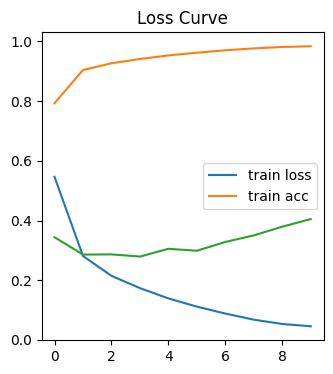

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

#基础配置
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
embed_dim = 64
hidden_dim = 128
epochs = 10
lr = 1e-3
max_len = 100
num_classes = 4

#加载设置
dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]

#tokenizer配置
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#dataset collate
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.texts = data["text"]
        self.labels = data["label"]

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    
def collate_fn(batch):
    texts, labels = zip(*batch)

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    return (
        encoded["input_ids"].to(device),
        torch.tensor(labels).to(device)
    )

#dataloader
train_loader = DataLoader(
    TextDataset(train_data),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    TextDataset(test_data),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

#LSTM分类模型
class LSTMclassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id
        )

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            #双向lstm
            bidirectional=True
        )

        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        """
        x: [batch_size, seq_len]
        """
        x = self.embedding(x)       #(B, T, E)
        _, (h_n, _) = self.lstm(x)

        # h_n: [num_layers * num_directions, B, H]
        # 取双向最后一层
        final_hidden = torch.cat(
            (h_n[-2], h_n[-1]), dim=1
        )

        return self.fc(final_hidden)
    
#初始化
model = LSTMclassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#训练+训练曲线
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(epochs):
    #train
    model.train()
    total_loss, correct, total = 0, 0, 0

    for input_ids, labels in train_loader:
        optimizer.zero_grad()

        logits = model(input_ids)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #eval
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for input_ids, labels in test_loader:
            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        test_loss = total_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f},"
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


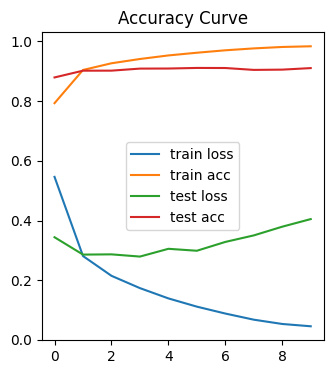

In [13]:

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train loss")
plt.plot(train_accs, label="train acc")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,1)
plt.plot(test_losses, label="test loss")
plt.plot(test_accs, label="test acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()